<a href="https://colab.research.google.com/github/kamaleshkio/Notebook/blob/main/Spam_Email_Detection_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud #text visualization

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

In [6]:
data = pd.read_csv("/content/spam_ham_dataset.csv")
data.head(3)

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0


In [7]:
data.shape

(5171, 4)

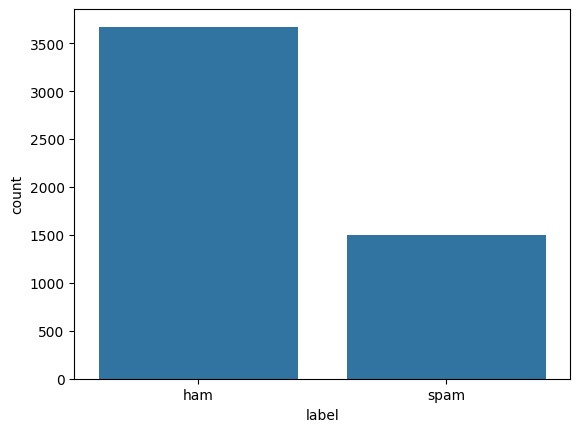

In [8]:
sns.countplot(x='label', data= data)
plt.show()

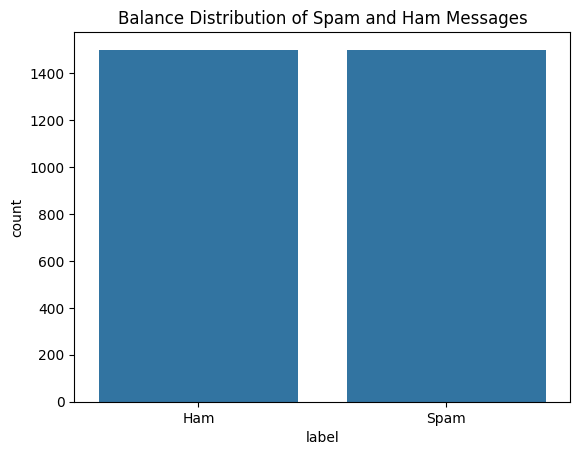

In [9]:
ham_msg = data[data['label'] == 'ham']
spam_msg = data[data['label'] == 'spam']

#Down sampling the "Ham"
ham_msg_balanced = ham_msg.sample(n = len(spam_msg), random_state = 42)

#combining the balanced data
balanced_data = pd.concat([ham_msg_balanced, spam_msg]).reset_index(drop=True)

#visualize the balanced dataset
sns.countplot(x='label', data = balanced_data)
plt.title("Balance Distribution of Spam and Ham Messages")
plt.xticks(ticks=[0, 1], labels=['Ham', 'Spam'])
plt.show()

In [10]:
punctuations_list = string.punctuation
punctuations_list


'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [11]:
def remove_punctuation(text):
  temp = str.maketrans("", "", punctuations_list)
  return text.translate(temp)

balanced_data['text'] = balanced_data['text'].apply(lambda x: remove_punctuation(x))
balanced_data.head()

,Unnamed: 0,label,text,label_num
0,3444,ham,Subject conoco big cowboy\r\ndarren \r\ni m ...,0
1,2982,ham,Subject feb 01 prod sale to teco gas processi...,0
2,2711,ham,Subject california energy crisis\r\ncalifornia...,0
3,3116,ham,Subject re nom actual volume for april 23 rd...,0
4,1314,ham,Subject eastrans nomination changes effective ...,0


In [12]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [13]:
# This function will remove stopwards from the text

def remove_stopwords(text):
  stop_words = stopwords.words('english')

  imp_words = []

  for word in text.split():
    word = word.lower()

    if word not in stop_words:
      imp_words.append(word)

  output = " ".join(imp_words)

  return output

# applying the funciton to the "Text" row

balanced_data['text'] = balanced_data['text'].apply(lambda text: remove_stopwords(text))
balanced_data.head(3)

,Unnamed: 0,label,text,label_num
0,3444,ham,subject conoco big cowboy darren sure help kno...,0
1,2982,ham,subject feb 01 prod sale teco gas processing s...,0
2,2711,ham,subject california energy crisis california  ...,0


In [14]:

# Visualization Word Cloud

def plot_word_cloud(data, typ):
  email_corp = " ".join(data['text'])
  wc = WordCloud(
      background_color='black', max_words=100, width=800, height=400
  ).generate(email_corp)
  plt.figure(figsize=(12, 6))
  plt.imshow(wc)
  plt.title(f"Word Cloud for {typ} Emails", fontsize=20)
  plt.axis('off')
  plt.show()


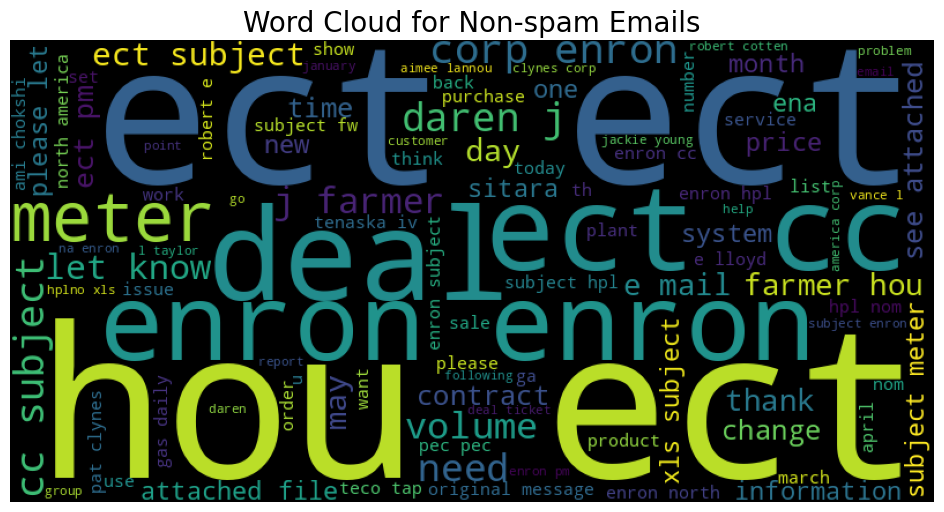

In [15]:
plot_word_cloud(balanced_data[balanced_data['label']=='ham'], typ = 'Non-spam')

In [16]:
#tokenaizign the text

train_X, test_X, train_y, test_y = train_test_split(balanced_data['text'],
                                                    balanced_data['label'],
                                                    test_size = 0.3,
                                                    random_state=42)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)
print(len(tokenizer.word_index))

train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)

print(len(train_sequences))
print(len(test_sequences))

36994
2098
900


In [17]:
# padding the tokenized word

max_len = 100

train_sequences = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
test_sequences = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

#print(train_sequences.shape)
#print(test_sequences.shape)



train_Y = (train_y == 'spam').astype(int)
test_Y = (test_y == 'spam').astype(int)
print(len(train_Y))
print(len(test_Y))
# defining the model

#--> Embedding Layer -- Learns vectore representation of words
#--> LSTM -- it will capture the patterns in sequences

model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim = len(tokenizer.word_index) + 1,
    output_dim = 32,
    input_length = max_len),
    tf.keras.layers.LSTM(16),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model.compile(
    loss = 'binary_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

model.summary()

2098
900


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [18]:
es = EarlyStopping(
    patience=3,
    monitor = 'val_accuracy',
    restore_best_weights=True)

lr = ReduceLROnPlateau(
    patience=2,
    monitor = 'val_score',
    factor = 0.5,
    verbose=0
)

In [19]:
history = model.fit(
    train_sequences, train_Y,
    validation_data=(test_sequences, test_Y),
    epochs=20,
    batch_size=32,
    callbacks=[lr, es]
)

Epoch 1/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.5546 - loss: 0.6911 - val_accuracy: 0.6333 - val_loss: 0.6589 - learning_rate: 0.0010
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8790 - loss: 0.4199 - val_accuracy: 0.9800 - val_loss: 0.1052 - learning_rate: 0.0010
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.9834 - loss: 0.0933 - val_accuracy: 0.9711 - val_loss: 0.1306 - learning_rate: 0.0010
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9889 - loss: 0.0651 - val_accuracy: 0.9733 - val_loss: 0.1179 - learning_rate: 0.0010
Epoch 5/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9933 - loss: 0.0420 - val_accuracy: 0.9789 - val_loss: 0.1035 - learning_rate: 0.0010


In [20]:
test_loss, test_accuracy = model.evaluate(test_sequences, test_Y)
print('Test Loss: ', test_loss)
print('Test Accucary: ', test_accuracy)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9813 - loss: 0.1021
Test Loss:  0.10519924014806747
Test Accucary:  0.9800000190734863


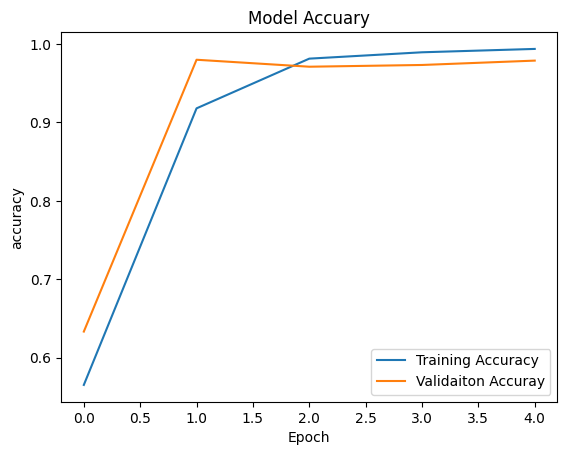

In [21]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validaiton Accuray')
plt.title('Model Accuary')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()